In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

Data Preprocessing

In [15]:
import pandas as pd
#df=pd.read_csv("./train.csv")
df=pd.read_csv("drive/My Drive/Colab Notebooks/Final Project/Task 1/train_add2.csv")
df.head()

,Pic Name,number of horizontal rebars,number of vertical rebars,Total rebars
0,20191024_100109_Depth_64669.png,8,9,17
1,20191024_100109_Depth_64594.png,8,9,17
2,20191024_100109_Depth_64690.png,8,9,17
3,20191024_095044_Depth_47399.png,7,7,14
4,20191024_095044_Depth_47300.png,7,7,14


In [16]:
#testdf=pd.read_csv("./testName.csv")
testdf=pd.read_csv("drive/My Drive/Colab Notebooks/Final Project/Task 1/testName.csv")
testdf.head()

,Pic Name
0,test_Depth_9280.png
1,20191024_10852_Depth_112034.png
2,test_Depth_14496.png
3,20190531_105600_Depth_5472.png
4,20190531_100725_Depth_20817.png


In [17]:
import os
from keras.preprocessing.image import ImageDataGenerator

# base_dir = '.\\train_img'
# train_dir = os.path.join(base_dir, 'train_img')
train_dir = 'drive/My Drive/Colab Notebooks/Final Project/Task 1/totalDepthPic'
valid_dir = 'drive/My Drive/Colab Notebooks/Final Project/Task 1/totalDepthPic'
test_dir = 'drive/My Drive/Colab Notebooks/Final Project/Task 1/totalDepthPic'

wh=150
BATCH_SIZE = 20

train_datagen = ImageDataGenerator(
         #rotation_range=15,
         #shear_range=0.1,
         #zoom_range=0.2,
         #horizontal_flip=True,
        rescale=1./255., 
        # validation_split=0.25
)
train_generator = train_datagen.flow_from_dataframe( 
    dataframe=df, 
    directory=train_dir, 
    x_col='Pic Name', 
    y_col='Total rebars', 
    has_ext=False,
#     subset="training", 
    class_mode="raw", 
    batch_size=BATCH_SIZE,
    target_size=(wh, wh)
    )

"""
vaild_datagen = ImageDataGenerator(
        rescale=1./255.
)
validation_generator = vaild_datagen.flow_from_dataframe( 
    dataframe=validf, 
    directory=valid_dir,
    x_col='Pic Name', 
    y_col='Total rebars', 
#     has_ext=False, 
#     subset="validation", 
    class_mode="raw",
    batch_size=BATCH_SIZE,
    target_size=(wh,wh)
    )
"""
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=testdf,
    directory=test_dir,
    x_col='Pic Name',
    target_size=(wh, wh),
    color_mode='rgb',
    shuffle=False,
    class_mode=None
)

Found 787 validated image filenames.
Found 101 validated image filenames.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 2 invalid image filename(s) in x_col="Pic Name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [0]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(wh, wh, 3)
)

In [19]:
import numpy as np

def extract_features(generator, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    batch_size = generator.batch_size
    # generator = datagen.flow_from_directory(
    #     directory,
    #     target_size=(150, 150),
    #     batch_size=batch_size,
    #     class_mode='binary')
    i = 0

    if generator.class_mode is None:
      for inputs_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i : (i + features_batch.shape[0])] = features_batch   # 避免最後一個batch的shape不合
        i += features_batch.shape[0]
        if i >= sample_count:
          # Note that since generators yield data indefinitely in a loop,
          # we must `break` after every image has been seen once.
          break
      return features
    else:
      for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        # features[i * batch_size : (i + 1) * batch_size] = features_batch
        features[i : (i + features_batch.shape[0])] = features_batch   # 避免最後一個batch的shape不合
        # labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        labels[i : (i + features_batch.shape[0])] = labels_batch
        i += features_batch.shape[0]
        if i >= sample_count:
          break
    print()
    return features, labels

train_features, train_labels = extract_features(train_generator, train_generator.samples)
test_features = extract_features(test_generator, test_generator.samples)

In [0]:
train_features = np.reshape(train_features, (train_generator.samples, 4 * 4 * 512))
test_features = np.reshape(test_features, (test_generator.samples, 4 * 4 * 512))

In [72]:
import xgboost as xgb

dtrain = xgb.DMatrix(data=train_features, label=train_labels)

# specify parameters via map
param = {
    'booster': 'dart',
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    # Tree Method
    # 'max_depth': 5,
    'learning_rate': 0.1,
    # 'subsample': 0.5,
    'sample_type': 'uniform',
    'normalize_type': 'tree',
    'rate_drop': 0.1,
    'skip_drop': 0.1,
    # Linear Method
    # 'reg_lambda':0.1,
    # 'reg_alpha':0.1,
    # 'updater':'coord_descent',
    # 'feature_selector':'shuffle',
}
NUM_ROUND = 60


bst = xgb.cv(
    params=param,
    dtrain=dtrain,
    num_boost_round=NUM_ROUND,
    nfold=5,
    # stratified=True,
    metrics='rmse'
)
bst.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
55,2.600819,1.803562,2.928695,0.593398
56,1.692136,0.850862,3.755369,1.270497
57,2.584101,0.812925,2.504225,0.787856
58,3.308457,1.289545,3.624118,1.348809
59,2.841047,0.912243,2.875695,0.439558


In [0]:
loss = bst['train-rmse-mean']
val_loss = bst['test-rmse-mean']

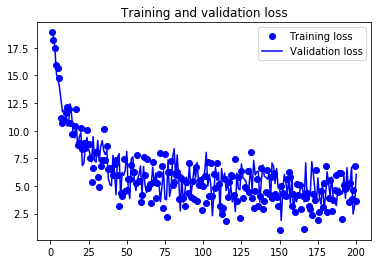

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
pred = model.predict(test_features)
pred

array([[24.741018 ],
       [14.462352 ],
       [21.104822 ],
       [29.435968 ],
       [13.738884 ],
       [14.3637   ],
       [32.51318  ],
       [14.936098 ],
       [14.622276 ],
       [14.481544 ],
       [32.825245 ],
       [16.375904 ],
       [14.185563 ],
       [23.973612 ],
       [28.02465  ],
       [10.454875 ],
       [14.382123 ],
       [ 8.877803 ],
       [29.81158  ],
       [13.544318 ],
       [12.853953 ],
       [26.766256 ],
       [13.878968 ],
       [23.772827 ],
       [23.530737 ],
       [16.196217 ],
       [37.070015 ],
       [14.768429 ],
       [27.671144 ],
       [28.388712 ],
       [14.288304 ],
       [13.466225 ],
       [23.913452 ],
       [14.344435 ],
       [16.532228 ],
       [27.88722  ],
       [16.776676 ],
       [16.260967 ],
       [13.304403 ],
       [16.530724 ],
       [24.0502   ],
       [29.274202 ],
       [14.368562 ],
       [14.357093 ],
       [16.065756 ],
       [14.965503 ],
       [35.67122  ],
       [36.84

In [0]:
testdf['Total rebars'] = pred
testdf.head

<bound method NDFrame.head of                             Pic Name  Total rebars
0                test_Depth_9280.png     24.741018
1    20191024_10852_Depth_112034.png     14.462352
2               test_Depth_14496.png     21.104822
3     20190531_105600_Depth_5472.png     29.435968
4    20190531_100725_Depth_20817.png     13.738884
..                               ...           ...
96              test_Depth_15136.png     23.002348
97              test_Depth_65208.png     25.333643
98   20190531_100633_Depth_19281.png      8.985611
99   20191024_095044_Depth_47316.png     13.201972
100  20191024_100019_Depth_63487.png     14.840062

[101 rows x 2 columns]>

In [0]:
#testdf.to_csv("./Result/wresult27.csv", index=False, encoding='utf-8')
testdf.to_csv("drive/My Drive/Colab Notebooks/Final Project/Task 1/Result/yoresult33.csv", index=False, encoding='utf-8')

In [0]:
model.save('drive/My Drive/Colab Notebooks/Final Project/Task 1/yomodel.h5')